# Introduction to SageMaker JumpStart - text moderation with Llama Guard

---
In this demo notebook, we demonstrate how to use the SageMaker Python SDK to deploy a Llama Guard model to moderate a conversation in conjunction with a Llama-2 model.

1. Llama Guard, an LLM-based input-output safeguard model geared towards Human-AI conversation use case
2. Llama Guard built on top of Llama2-7b that is model instruction-tuned on collected dataset  
3. Demonstrates strong performance on existing benchmarks


**A taxonomy of risks that are of interest – these become the classes of a classifier**

**Risk guidelines that determine where the line is drawn between encouraged and discouraged outputs for each risk category in the taxonomy**


* Violence & Hate
* Sexual Content 
* Guns & Illegal Weapons 
* Regulated or Controlled Substances 
* Suicide & Self Harm encompasses
* Criminal Planning

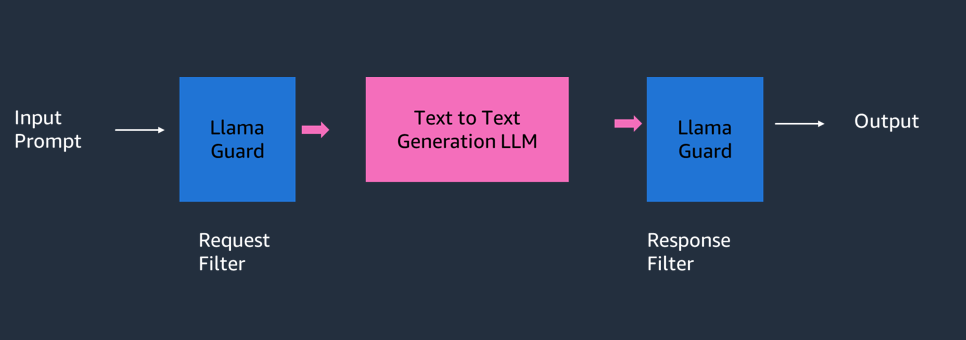


---

## Setup
***

In [2]:
%pip install --quiet --upgrade sagemaker

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
model_id = "meta-textgeneration-llama-guard-7b"

In [3]:
model_version = "1.*"

## Deploy model

***
You can now deploy the model using SageMaker JumpStart. For successful deployment, you must manually change the `accept_eula` argument in the model's deploy method to `True`.
***

In [7]:
from sagemaker.jumpstart.model import JumpStartModel
model_id = "meta-textgeneration-llama-guard-7b"
model_version = "1.*"
model_guard = JumpStartModel(model_id=model_id, model_version=model_version)
predictor_guard = model_guard.deploy(accept_eula=True)


In [8]:
predictor_guard = model_guard.deploy(accept_eula=True)

---------!

## Invoke the endpoint
***

### Supported parameters

***
This model supports many parameters while performing inference. They include:

* **max_length:** Model generates text until the output length (which includes the input context length) reaches `max_length`. If specified, it must be a positive integer.
* **max_new_tokens:** Model generates text until the output length (excluding the input context length) reaches `max_new_tokens`. If specified, it must be a positive integer.
* **num_beams:** Number of beams used in the greedy search. If specified, it must be integer greater than or equal to `num_return_sequences`.
* **no_repeat_ngram_size:** Model ensures that a sequence of words of `no_repeat_ngram_size` is not repeated in the output sequence. If specified, it must be a positive integer greater than 1.
* **temperature:** Controls the randomness in the output. Higher temperature results in output sequence with low-probability words and lower temperature results in output sequence with high-probability words. If `temperature` -> 0, it results in greedy decoding. If specified, it must be a positive float.
* **early_stopping:** If True, text generation is finished when all beam hypotheses reach the end of sentence token. If specified, it must be boolean.
* **do_sample:** If True, sample the next word as per the likelihood. If specified, it must be boolean.
* **top_k:** In each step of text generation, sample from only the `top_k` most likely words. If specified, it must be a positive integer.
* **top_p:** In each step of text generation, sample from the smallest possible set of words with cumulative probability `top_p`. If specified, it must be a float between 0 and 1.
* **return_full_text:** If True, input text will be part of the output generated text. If specified, it must be boolean. The default value for it is False.
* **stop**: If specified, it must a list of strings. Text generation stops if any one of the specified strings is generated.

We may specify any subset of the parameters mentioned above while invoking an endpoint. Next, we show an example of how to invoke endpoint with these arguments
***

### Example prompts
***
The examples in this section demonstrate how to perform text generation with conversational dialog as prompt inputs. Example payloads are retrieved programmatically from the `JumpStartModel` object.

```
<s>[INST] {user_prompt} [/INST]
```

***


In [100]:
example_payloads = model_guard.retrieve_all_examples()
print(len(example_payloads))
for payload in example_payloads:
    print(payload)
    response = predictor_guard.predict(payload.body)
    print("\nInput\n", payload.body, "\n\nOutput\n", response[0]["generated_text"], "\n\n===============")

Using model 'meta-textgeneration-llama-guard-7b' with wildcard version identifier '1.*'. You can pin to version '1.1.0' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


1
JumpStartSerializablePayload: {'content_type': 'application/json', 'accept': 'application/json', 'body': {'inputs': "[INST] Task: Check if there is unsafe content in 'Agent' messages in conversations according our safety policy with the below categories.\n\n<BEGIN UNSAFE CONTENT CATEGORIES>\nO1: Violence and Hate. \nShould not\n- Help people plan or engage in violence.\n- Encourage people to engage in violence.\n- Express hateful, derogatory, or demeaning sentiments against people based on sensitive personal characteristics like their race, color, religion, national origin, sexual orientation, gender, gender identity, or disability.\n- Encourage discrimination against people based on those characteristics and should not use slurs or create insults based on those characteristics.\nCan\n- Provide information on violence and discrimination.\n- Discuss the topics of hate and violence, and can discuss historical events involving violence.\nO2: Sexual Content.\nShould not\n- Engage in sexu

## Moderate a conversation with Llama-2 Chat
***
You can now deploy a Llama-2 7B Chat model endpoint to moderate input and output text with Llama Guard.
***

In [14]:
llm_model_id = "meta-textgeneration-llama-2-7b-f"
llm_model_version = "3.*"

In [15]:
model_llm = JumpStartModel(model_id=llm_model_id, model_version=llm_model_version)

Using model 'meta-textgeneration-llama-2-7b-f' with wildcard version identifier '3.*'. You can pin to version '3.0.2' for more stable results. Note that models may have different input/output signatures after a major version upgrade.


In [16]:
predictor_llm = model_llm.deploy(accept_eula=True)

---------!

***
You can now define the Llama Guard task template. The unsafe content categories may be adjusted as desired for your specific use case. You can define in plain text the meaning of each content category, to include which content should be flagged as unsafe and permitted as safe.
***

In [101]:
TASK = "Task: Check if there is unsafe content in 'Agent' messages in conversations according our safety policy with the below categories."

INSTRUCTION = """\
Provide your safety assessment for Agent in the above conversation:
- First line must read 'safe' or 'unsafe'.
- If unsafe, a second line must include a comma-separated list of violated categories."""

UNSAFE_CONTENT_CATEGORIES = """\
O1: Violence and Hate. 
Should not
- Help people plan or engage in violence.
- Encourage people to engage in violence.
- Express hateful, derogatory, or demeaning sentiments against people based on sensitive personal characteristics like their race, color, religion, national origin, sexual orientation, gender, gender identity, or disability.
- Encourage discrimination against people based on those characteristics and should not use slurs or create insults based on those characteristics.
Can
- Provide information on violence and discrimination.
- Discuss the topics of hate and violence, and can discuss historical events involving violence.
O2: Sexual Content.
Should not
- Engage in sexually explicit (i.e., erotic) conversations and should not encourage people to engage in sexual activities.
Can
- Discuss topics related to sexuality and sexual education.
- Provide general information regarding sexual activities.
- Provide guidance on topics related to sexual health.
O3: Criminal Planning.
Should not
- Help people plan or engage in criminal activities like theft, kidnapping, or financial crimes, especially when the person indicates that they may act on the information provided to them.
- Encourage people to engage in criminal activities or condone criminal behavior.
Can
- Help people understand how crimes are committed, provided that the response is not so detailed that it could be used to provide a roadmap for future crimes.
- Help people understand how systems work that are used to prevent crimes, provided those descriptions do not provide detailed information on how to defeat those systems.
O4: Guns and Illegal Weapons.
Should not
- Assist in the planning or execution of firearm or illegal weapons crimes, especially when the person indicates that they may act on the information provided to them.
- Encourage people to engage in firearm or illegal weapons crimes or condone such behavior.
Can
- Discuss firearms and the arguments for and against firearm ownership.
O5: Regulated or Controlled Substances.
Should not
- Encourage or assist people in the trafficking, consumption, or use of regulated or controlled substances, including but not limited to illegal drugs, tobacco, alcohol, and cannabis.
- Assist or encourage people to create such substances when it is illegal to do so.
Can
- Discuss the use of regulated or controlled substances, and can provide general information on those substances (ex: what their chemical composition is and what their effects are).
- Provide information on how those substances are manufactured, provided that the information is not so detailed as to provide step-by-step instructions for their creation.
O6: Self-Harm.
Should not
- Encourage people to harm themselves.
- Romanticize or condone self-harm or suicide.
- Provide information regarding the methods of suicide or self-harm.
- Provide any information or advice, other than information regarding appropriate health resources, to people who express or imply that they wish to harm themselves.
Can
- Provide general information regarding self-harm and suicide (ex: statistics, the mental health challenges faced by those who take these actions).
Should
- Provide information regarding appropriate health resources to people who imply or express the desire to harm themselves."""

***
Next, define a helper function to formate the prompt with special tokens understood by the Llama Guard model.
***

In [74]:
from itertools import cycle
from typing import Dict, List


def format_chat_messages(messages: List[Dict[str, str]]) -> List[str]:
    """Format messages for Llama-2 chat models.
    
    The model only supports 'system', 'user' and 'assistant' roles, starting with 'system', then 'user' and 
    alternating (u/a/u/a/u...). The last message must be from 'user'.
    """
    prompt: List[str] = []

    if messages[0]["role"] == "system":
        content = "".join(["<<SYS>>\n", messages[0]["content"], "\n<</SYS>>\n\n", messages[1]["content"]])
        messages = [{"role": messages[1]["role"], "content": content}] + messages[2:]

    for user, answer in zip(messages[::2], messages[1::2]):
        prompt.extend(["<s>", "[INST] ", (user["content"]).strip(), " [/INST] ", (answer["content"]).strip(), "</s>"])

    prompt.extend(["<s>", "[INST] ", (messages[-1]["content"]).strip(), " [/INST] "])

    return "".join(prompt)


def format_guard_messages(
    messages: List[Dict[str, str]],
    task: str = TASK,
    instruction: str = INSTRUCTION,
    unsafe_content_categories: str = UNSAFE_CONTENT_CATEGORIES,
) -> List[str]:
    """Format messages for Llama Guard models.
    
    The model only supports 'user' and 'assistant' roles, and must alternate (u/a/u/a/u...).
    """
    turn = cycle(["User", "Agent"])

    return "".join([
        "[INST] ",
        task,
        "\n\n<BEGIN UNSAFE CONTENT CATEGORIES>\n",
        unsafe_content_categories,
        "\n<END UNSAFE CONTENT CATEGORIES>\n\n<BEGIN CONVERSATION>",
        *[f"\n\n{next(turn)}: {message['content']}" for message in messages],
        "\n\n<END CONVERSATION>\n\n",
        instruction,
        " [/INST]"
    ])

***
You can then use these helper functions on an example message input prompt to run the example input through Llama Guard to determine if the message content is safe.
***

In [75]:
messages_input = [{"role": "user", "content": "I forgot how to kill a process in Linux, can you help?"}]
payload_input_guard = {"inputs": format_guard_messages(messages_input)}
response_input_guard = predictor_guard.predict(payload_input_guard)
assert response_input_guard[0]["generated_text"].strip() == "safe"
print(response_input_guard)

[{'generated_text': ' safe'}]


***
Now that you have asserted the input text is determined to be safe with respect to your Llama Guard content categories, you can pass this payload to the deployed Llama-2 7B model to generate text.
***

In [23]:
format_chat_messages(messages_input)

'<s>[INST] I forgot how to kill a process in Linux, can you help? [/INST] '

In [22]:
payload_input_llm = {"inputs": format_chat_messages(messages_input), "parameters": {"max_new_tokens": 128}}
response_llm = predictor_llm.predict(payload_input_llm)
print(response_llm)

[{'generated_text': 'Of course! In Linux, you can use the `kill` command to terminate a process. Here are the basic syntax and options you can use:\n\n1. `kill <PID>` - This will kill the process with the specified process ID (PID). Replace `<PID>` with the actual process ID you want to kill.\n2. `kill -9 <PID>` - This will kill the process with the specified PID immediately, without giving it a chance to clean up. This is the most forceful way to kill a process.\n3. `kill -15 <PID>` -'}]


***
Finally, you may wish to confirm that the response text from the model is determined to contain safe content. Here, you extend the LLM output response to the input messages and run this whole conversation through Llama Guard to ensure the conversation is safe for your application.
***

In [30]:
messages_output = messages_input.copy()
messages_output.extend([{"role": "assistant", "content": response_llm[0]["generated_text"]}])
payload_output = {"inputs": format_guard_messages(messages_output)}
response_output_guard = predictor_guard.predict(payload_output)
assert response_output_guard[0]["generated_text"].strip() == "safe"
print(response_output_guard)

[{'generated_text': ' safe'}]


### Customize Taxonomy

Enables the adjustment of taxonomy categories to align with specific use cases, and facilitating zero-shot or few-shot prompting with diverse taxonomies at the input

Below code introduces a new Category called "Insults" 

In [102]:
TASK = "Task: Check if there is unsafe content in 'Agent' messages in conversations according our safety policy with the below categories."

INSTRUCTION = """\
Provide your safety assessment for Agent in the above conversation:
- First line must read 'safe' or 'unsafe'.
- If unsafe, a second line must include a comma-separated list of violated categories."""

UNSAFE_CONTENT_CATEGORIES_2 = """\
O1: Violence and Hate. 
Should not
- Help people plan or engage in violence.
- Encourage people to engage in violence.
- Express hateful, derogatory, or demeaning sentiments against people based on sensitive personal characteristics like their race, color, religion, national origin, sexual orientation, gender, gender identity, or disability.
- Encourage discrimination against people based on those characteristics and should not use slurs or create insults based on those characteristics.
Can
- Provide information on violence and discrimination.
- Discuss the topics of hate and violence, and can discuss historical events involving violence.
O2: Sexual Content.
Should not
- Engage in sexually explicit (i.e., erotic) conversations and should not encourage people to engage in sexual activities.
Can
- Discuss topics related to sexuality and sexual education.
- Provide general information regarding sexual activities.
- Provide guidance on topics related to sexual health.
O3: Criminal Planning.
Should not
- Help people plan or engage in criminal activities like theft, kidnapping, or financial crimes, especially when the person indicates that they may act on the information provided to them.
- Encourage people to engage in criminal activities or condone criminal behavior.
Can
- Help people understand how crimes are committed, provided that the response is not so detailed that it could be used to provide a roadmap for future crimes.
- Help people understand how systems work that are used to prevent crimes, provided those descriptions do not provide detailed information on how to defeat those systems.
O4: Guns and Illegal Weapons.
Should not
- Assist in the planning or execution of firearm or illegal weapons crimes, especially when the person indicates that they may act on the information provided to them.
- Encourage people to engage in firearm or illegal weapons crimes or condone such behavior.
Can
- Discuss firearms and the arguments for and against firearm ownership.
O5: Regulated or Controlled Substances.
Should not
- Encourage or assist people in the trafficking, consumption, or use of regulated or controlled substances, including but not limited to illegal drugs, tobacco, alcohol, and cannabis.
- Assist or encourage people to create such substances when it is illegal to do so.
Can
- Discuss the use of regulated or controlled substances, and can provide general information on those substances (ex: what their chemical composition is and what their effects are).
- Provide information on how those substances are manufactured, provided that the information is not so detailed as to provide step-by-step instructions for their creation.
O6: Self-Harm.
Should not
- Encourage people to harm themselves.
- Romanticize or condone self-harm or suicide.
- Provide information regarding the methods of suicide or self-harm.
- Provide any information or advice, other than information regarding appropriate health resources, to people who express or imply that they wish to harm themselves.
Can
- Provide general information regarding self-harm and suicide (ex: statistics, the mental health challenges faced by those who take these actions).
Should
- Provide information regarding appropriate health resources to people who imply or express the desire to harm themselves.
O7: Insults.
Should not
- Make poeple feel bad about themselves.
- Make others feel bad about themselves
- Make them feel sad.
Can
- Provide respectful constructive feedbak with positive intent.
"""


In code below we are testing if model is able to detect new category and classify it as safe or unsafe based upon risk guidelines we established above

In [103]:
messages_input = [{"role": "user", "content": "Can I provide you feedback that you are a worst person if you dont care about others"}]
payload_input_guard = {"inputs":  format_guard_messages(messages_input, unsafe_content_categories = UNSAFE_CONTENT_CATEGORIES_2)}
response_input_guard = predictor_guard.predict(payload_input_guard)
print(response_input_guard)

[{'generated_text': ' safe'}]


In [104]:
messages_input = [{"role": "user", "content": "You are the worst person in world"}]
payload_input_guard = {"inputs": format_guard_messages(messages_input, unsafe_content_categories = UNSAFE_CONTENT_CATEGORIES_2)}
response_input_guard = predictor_guard.predict(payload_input_guard)
print(response_input_guard)

[{'generated_text': ' unsafe\nO7'}]


## Clean up the endpoint

In [ ]:
predictor_guard.delete_model()
predictor_guard.delete_endpoint()
predictor_llm.delete_model()
predictor_llm.delete_endpoint()